## Calculate tumor size: largest diameters and volumes

In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
from skimage import measure
import itertools as it


# calculate volume / number of pixels for a given label
# mask: slices of ROIs, ndarray, [nx, ny, nslc]
# mask_res: spatial resolution of a mask voxel, ndarray, [nx, ny, nslc]
# label_ind: index of the specified label, int
def mask_vol_cal(mask, mask_res, label_ind=1):
    [nx, ny, nslc] = mask_res
    volume = len(np.extract(mask == label_ind, mask)) * nx * ny * nslc
    return volume


# res_2d: 2D spatial resolution
def distance_axial(a_coord, b_coord, res_2d):
    [nx, ny] = res_2d
    spatial_diff = (a_coord - b_coord) * res_2d
    return np.linalg.norm(spatial_diff)


# calculate max diameter for each slice 
# mask: slices of ROIs, ndarray, [nx, ny, nslc]
# mask_res: spatial resolution of a mask voxel, ndarray, [nx, ny, nslc]
# label_ind: index of the specified label, int
def mask_diam_cal(mask, mask_res, label_ind=1):
    mask = (mask == label_ind)
    [nx, ny, nslc] = mask_res
    dist_3d = []
    for ii in np.arange(mask.shape[2]):
        mask_2d = mask[:, :, ii]
        if np.sum(mask_2d) > 0:
            contours_2d = measure.find_contours(mask_2d)
            dist_2d = [] 
            for pixel in it.combinations(list(contours_2d[0]), 2):
                dist_2d.append(distance_axial(pixel[0], pixel[1], [nx, ny]))
            dist_3d.append(max(np.array(dist_2d)))
    dist_z_max = len(dist_3d) * nslc
    dist_3d.append(dist_z_max)   
    
    return max(np.array(dist_3d))
    

def getFileName1(path,suffix):
    # get files with suffix
    input_template_All=[]
    f_list = os.listdir(path)
    for i in f_list:
        if os.path.splitext(i)[1] ==suffix:
            input_template_All.append(i)
    return input_template_All

def get_imgs_all(fname):
    # .nii.gz files: split twice
    fname = os.path.splitext(fname)[0]
    fname = os.path.splitext(fname)[0]
    
    img_fname = os.path.join(imgs_path, fname + "_0000.nii.gz")
    lab_fname = os.path.join(labs_path, fname + ".nii.gz")
    pre_fname = os.path.join(preds_path, fname + ".nii.gz")
    
    img = nib.load(img_fname)
    lab = nib.load(lab_fname)
    pre = nib.load(pre_fname)

    img = img.get_fdata()
    lab = lab.get_fdata()
    pre = pre.get_fdata()

    return img, lab, pre

def detect_largest_ROI(lab):
    a = np.sum(lab, axis=0)
    b = np.sum(a, axis=0)
    return np.argmax(b)     
        

def img_standarize(img):
    window_center = 40.0
    window_width = 400.0
    
    win_min = (2*window_center - window_width)/2.0 + 0.5  
    win_max = (2*window_center + window_width)/2.0 + 0.5    
    dFactor = 255.0/(win_max - win_min)
    
    img_win = img
    img_win[img < win_min] = win_min
    img_win[img > win_max] = win_max
    img_win = (img_win - win_min)/(win_max - win_min)
    
    return img_win


In [2]:
labs_path = "/scratch/yiang/nnUNet/nnUNet_pred/Task102_CaOvarySeg_HK/labelsTs/"
preds_path = "/scratch/yiang/nnUNet/nnUNet_pred/Task102_CaOvarySeg_HK/op_3d_cascade/"
js_path = './Results_v3/3d_cascade.json'

In [8]:
def df_summary(js_path):
    with open(js_path, "r") as f:
        js_data = json.load(f)
    
    metrics_all = js_data["results"]["all"]
    df = pd.DataFrame(columns=metrics_all[0]["1"].keys())
    df.insert(0, "No.", "")
    df['No.'] = df['No.'].astype('string')

    for ii in np.arange(len(metrics_all)):
        df = df.append(metrics_all[ii]["1"], ignore_index=True)
        df.at[ii, "No."] = metrics_all[ii]["reference"][-12:-7]
        fpath = metrics_all[ii]["reference"]
        mask = nib.load(fpath)
        mask_res = mask.header.get_zooms()
        mask = mask.get_fdata()
        df.at[ii, "Tumor Volume"] = mask_vol_cal(mask, mask_res)
        df.at[ii, "Tumor Diameter"] = mask_diam_cal(mask, mask_res)
            
    return df


df_comb = df_summary(js_path)
df_comb

,No.,Accuracy,Dice,False Discovery Rate,False Negative Rate,False Omission Rate,False Positive Rate,Jaccard,Negative Predictive Value,Precision,Recall,Total Positives Reference,Total Positives Test,True Negative Rate,Tumor Volume,Tumor Diameter
0,DR192,0.998779,0.937932,0.084390,0.038630,0.000374,0.000858,0.883119,0.999626,0.915610,0.961370,203752.0,213935.0,0.999142,3.497641e+05,122.246379
1,DR234,0.997237,0.925795,0.087295,0.060734,0.001136,0.001679,0.861843,0.998864,0.912705,0.939266,380052.0,391112.0,0.998321,7.422891e+05,135.889719
2,DR480,0.999625,0.958006,0.062565,0.020501,0.000090,0.000287,0.919396,0.999910,0.937435,0.979499,119164.0,124511.0,0.999713,2.327422e+05,93.516376
3,DR507,0.996898,0.977212,0.026431,0.019116,0.001391,0.001937,0.955440,0.998609,0.973569,0.980884,1350884.0,1361034.0,0.998063,2.978553e+06,225.000000
4,DR521,0.998118,0.955180,0.077642,0.009576,0.000198,0.001723,0.914205,0.999802,0.922358,0.990424,424605.0,455939.0,0.998277,7.288840e+05,126.293763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,PY409,0.998710,0.860049,0.078667,0.193590,0.000955,0.000340,0.754462,0.999045,0.921333,0.806410,112077.0,98097.0,0.999660,3.152166e+05,112.939143
80,PY411,0.998959,0.912538,0.143549,0.023514,0.000132,0.000915,0.839145,0.999868,0.856451,0.976486,123928.0,141297.0,0.999085,3.235959e+05,115.000000
81,PY412,0.997774,0.923264,0.064702,0.088464,0.001319,0.000940,0.857466,0.998681,0.935298,0.911536,335086.0,326573.0,0.999060,8.749633e+05,154.536960
82,PY413,0.997656,0.915489,0.136726,0.025572,0.000338,0.002037,0.844149,0.999662,0.863274,0.974428,324458.0,366235.0,0.997963,8.835705e+05,156.222585


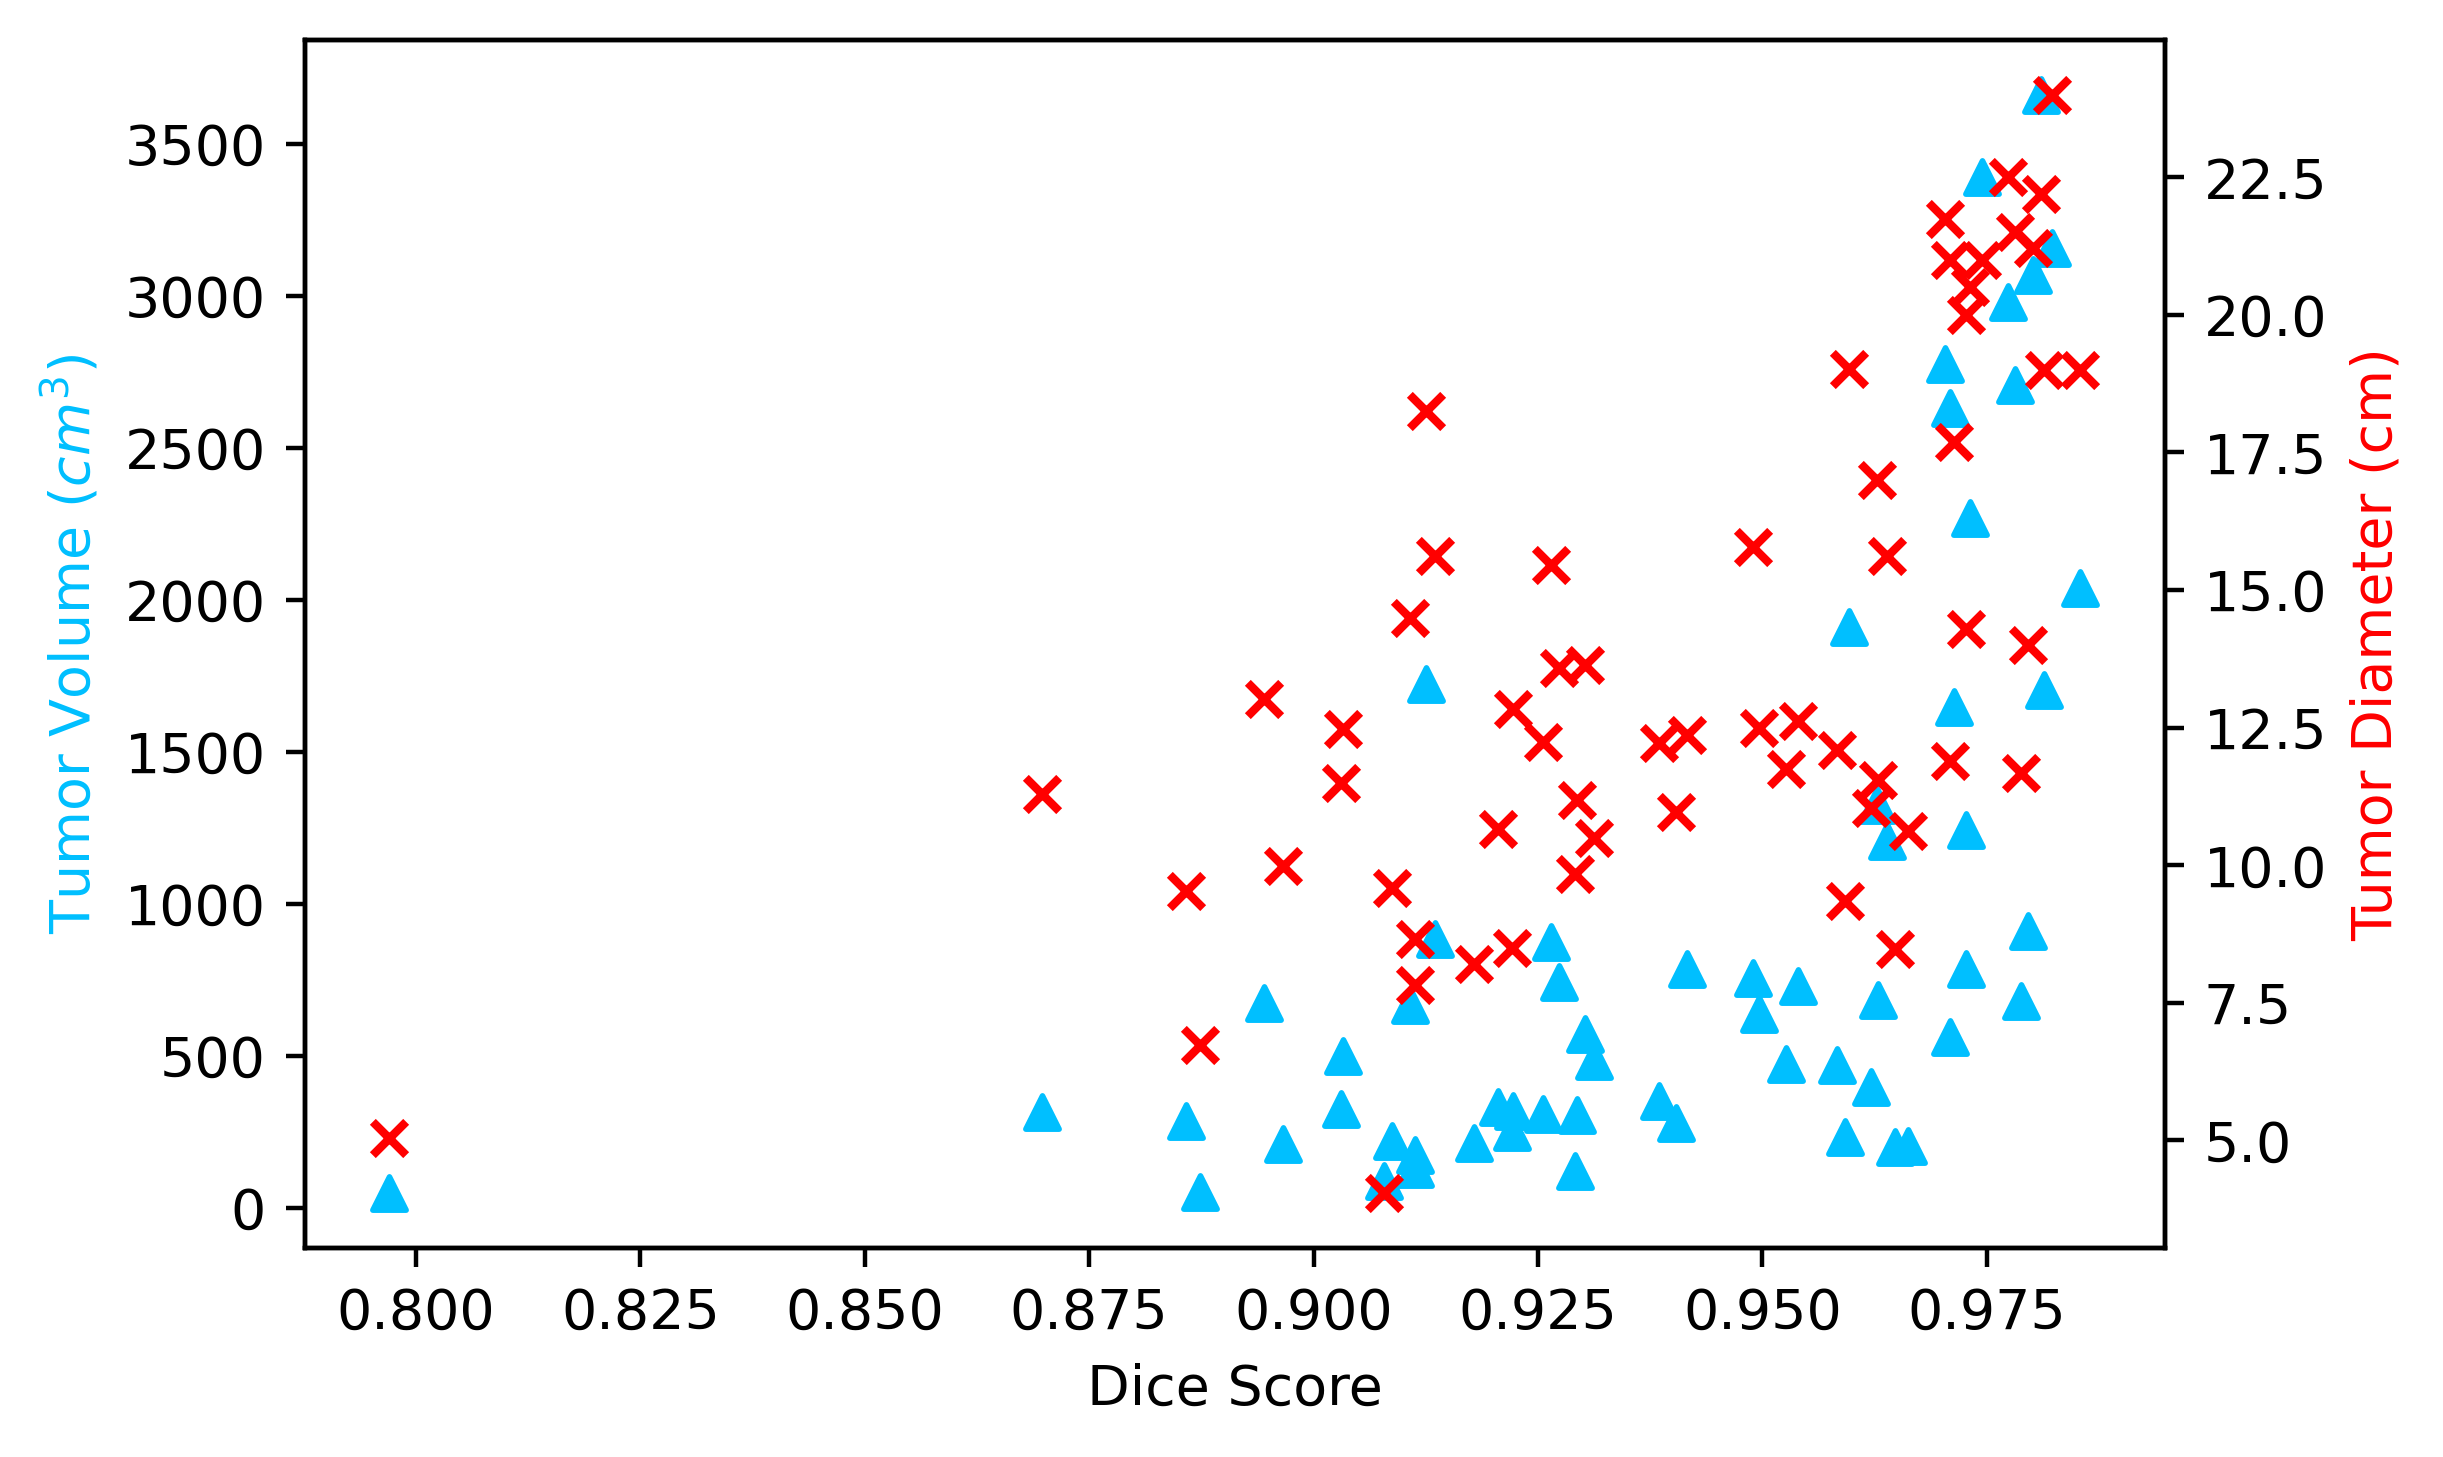

In [4]:
fig, ax1 = plt.subplots(dpi=400)
ax2 = ax1.twinx()

ax1.scatter(np.array(df_comb["Dice"]), np.array(df_comb["Tumor Volume"]) * 0.001, color='deepskyblue', marker='^')
ax2.scatter(np.array(df_comb["Dice"]), np.array(df_comb["Tumor Diameter"]) * 0.1, color='red', marker='x')

ax1.set_xlabel("Dice Score")
ax1.set_ylabel("Tumor Volume ($cm^3$)", color = 'deepskyblue')
ax2.set_ylabel("Tumor Diameter (cm)", color = 'red')

# plt.savefig("Fig2.tiff", dpi=400)
plt.show()

In [3]:
def df_summary(js_path):
    with open(js_path, "r") as f:
        js_data = json.load(f)
    
    metrics_all = js_data["results"]["all"]
    df = pd.DataFrame(columns=metrics_all[0]["1"].keys())
    df.insert(0, "No.", "")
    df['No.'] = df['No.'].astype('string')
    
    for ii in np.arange(len(metrics_all)):
        df = df.append(metrics_all[ii]["1"], ignore_index=True)
        df.at[ii, "No."] = metrics_all[ii]["reference"][-12:-7]
        fpath0 = metrics_all[ii]["reference"]
        mask0 = nib.load(fpath0)
        mask0_res = mask0.header.get_zooms()
        mask0 = mask0.get_fdata()
        df.at[ii, "Volume_GT"] = mask_vol_cal(mask0, mask0_res)/1000
        
        fpath1 = metrics_all[ii]["test"]
        mask1 = nib.load(fpath1)
        mask1_res = mask1.header.get_zooms()
        mask1 = mask1.get_fdata()
        df.at[ii, "Volume_PD"] = mask_vol_cal(mask1, mask1_res)/1000
            
    return df

labs_path = "/scratch/yiang/nnUNet/nnUNet_pred/Task102_CaOvarySeg_HK/labelsTs/"
preds_path = "/scratch/yiang/nnUNet/nnUNet_pred/Task102_CaOvarySeg_HK/op_3d_cascade/"
js_path = './Results_v3/3d_cascade.json'

df_comb = df_summary(js_path)
df_comb

,No.,Accuracy,Dice,False Discovery Rate,False Negative Rate,False Omission Rate,False Positive Rate,Jaccard,Negative Predictive Value,Precision,Recall,Total Positives Reference,Total Positives Test,True Negative Rate,Volume_GT,Volume_PD
0,DR192,0.998774,0.937895,0.087752,0.034974,0.000339,0.000899,0.883054,0.999661,0.912248,0.965026,203752.0,215540.0,0.999101,349.764058,369.999534
1,DR234,0.997236,0.926951,0.100106,0.044315,0.000829,0.001987,0.863848,0.999171,0.899894,0.955685,380052.0,403614.0,0.998013,742.289062,788.308594
2,DR480,0.999640,0.959698,0.059837,0.019939,0.000088,0.000274,0.922518,0.999912,0.940163,0.980061,119164.0,124221.0,0.999726,232.742188,242.619141
3,DR507,0.996780,0.976459,0.031824,0.015115,0.001101,0.002355,0.954000,0.998899,0.968176,0.984885,1350884.0,1374198.0,0.997645,2978.553126,3029.957975
4,DR521,0.998011,0.952649,0.080581,0.011630,0.000241,0.001790,0.909579,0.999759,0.919419,0.988370,424605.0,456448.0,0.998210,728.883976,783.546197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,PY409,0.998750,0.868962,0.104092,0.156410,0.000772,0.000484,0.768288,0.999228,0.895908,0.843590,112077.0,105532.0,0.999516,315.216563,296.808750
80,PY411,0.998242,0.861128,0.231984,0.020068,0.000112,0.001655,0.756124,0.999888,0.768016,0.979932,123928.0,158123.0,0.998345,323.595871,412.884497
81,PY412,0.997867,0.927699,0.075987,0.068585,0.001023,0.001142,0.865148,0.998977,0.924013,0.931415,335086.0,337770.0,0.998858,874.963253,881.971607
82,PY413,0.997544,0.911853,0.143784,0.024777,0.000328,0.002162,0.837987,0.999672,0.856216,0.975223,324458.0,369555.0,0.997838,883.570457,1006.379501


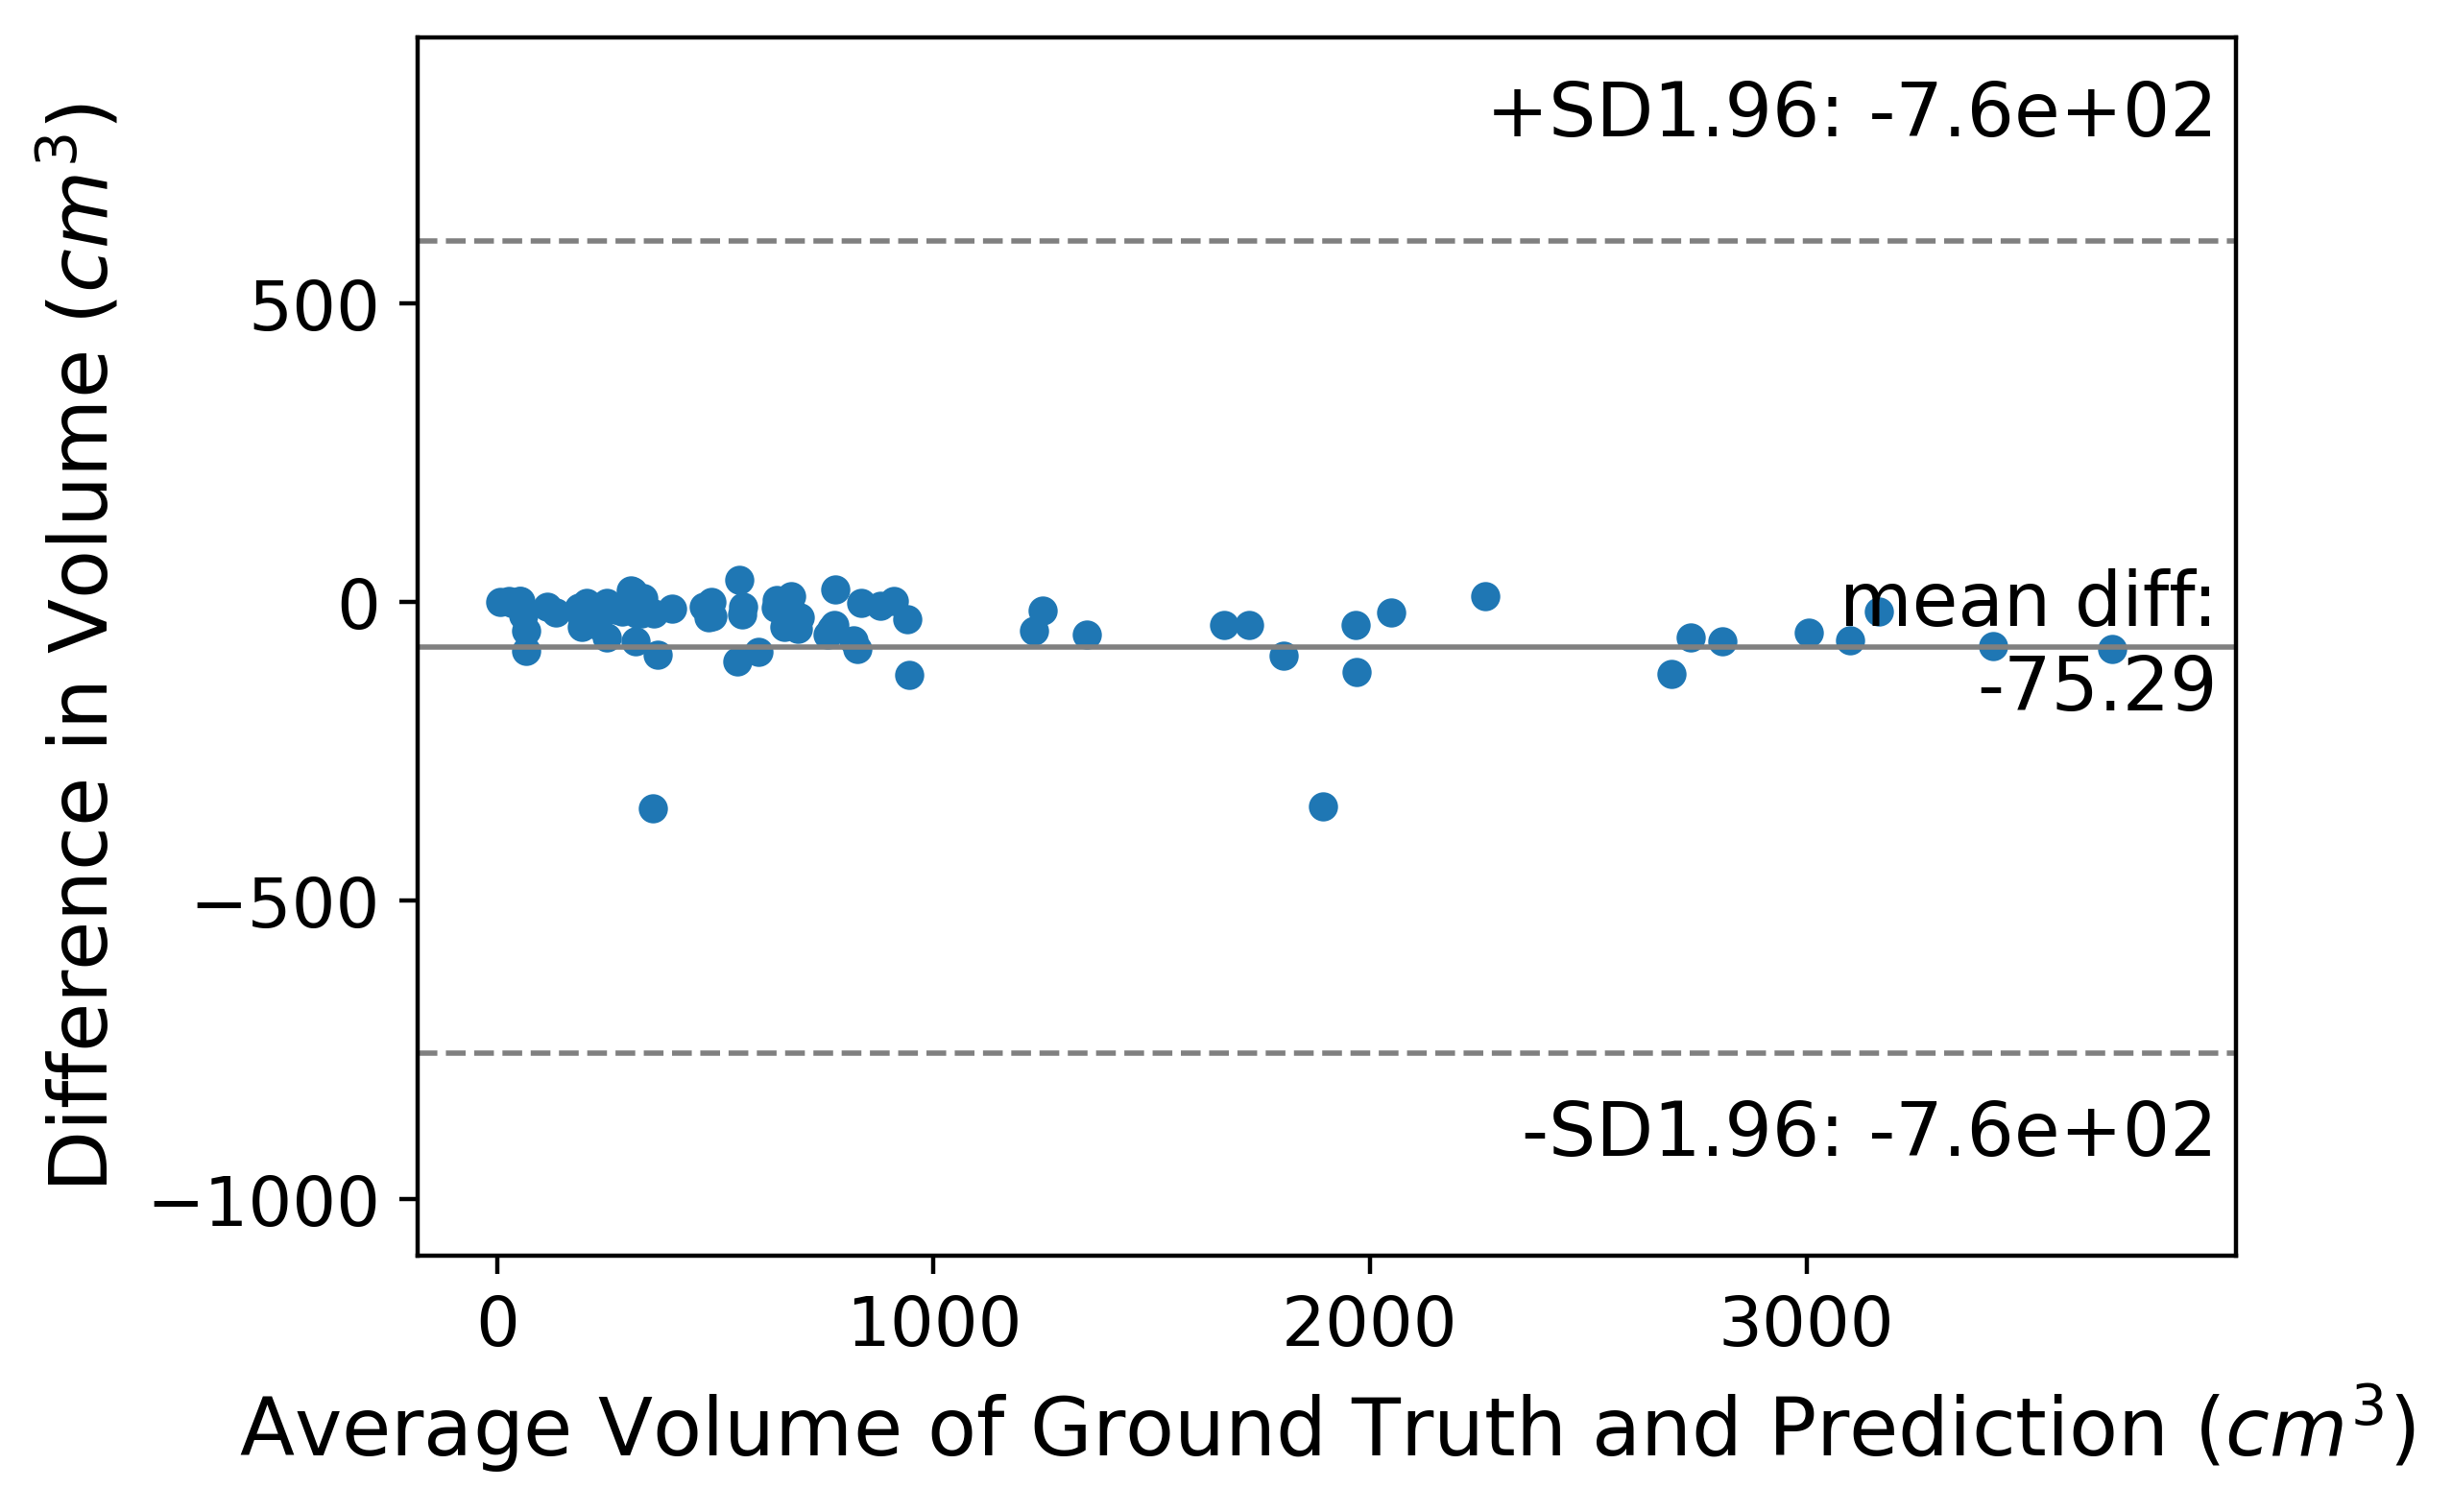

In [5]:
import statsmodels.api as sm

f, ax = plt.subplots(dpi=400)
sm.graphics.mean_diff_plot(df_comb['Volume_GT'], df_comb['Volume_PD'], ax = ax)

ax.set_xlabel("Average Volume of Ground Truth and Prediction ($cm^3$)")
ax.set_ylabel("Difference in Volume ($cm^3$)")

plt.savefig("Fig6a.tiff", bbox_inches='tight', dpi=400)
plt.show()


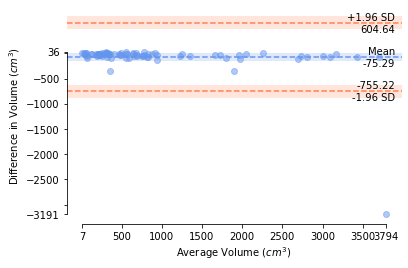

In [16]:
import pyCompare

f, ax = plt.subplots()
# ax.text(10, 10, "(a)", size=16, color='lime')
# ax.set_aspect('auto')

pyCompare.blandAltman(df_comb['Volume_GT'], df_comb['Volume_PD'], ax=ax)
ax.set_xlabel("Average Volume ($cm^3$)")
ax.set_ylabel("Difference in Volume ($cm^3$)")
# ax.set_aspect('auto')
# ax.set_ybound(lower=-2750, upper=540)
# ax.set_ylim(bottom=3200, top=610)

# plt.savefig("Fig4a.tiff", bbox_inches='tight', dpi=400)
plt.show()

In [6]:
import scipy
pearson_coeff = scipy.stats.pearsonr(df_comb['Volume_GT'], df_comb['Volume_PD'])
print(pearson_coeff)

(0.9438449039544712, 3.3748879459654936e-41)


In [6]:
def r(x,y):
    ''' Pearson Correlation Coefficient'''
    sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
    rho = sxy / (np.std(x)*np.std(y))
    return rho

print(r(df_comb['Volume_GT'], df_comb['Volume_PD']))

0.9438449039544715


In [7]:
def concordance_correlation_coefficient(y_true, y_pred,
                       sample_weight=None,
                       multioutput='uniform_average'):
    """Concordance correlation coefficient.
    The concordance correlation coefficient is a measure of inter-rater agreement.
    It measures the deviation of the relationship between predicted and true values
    from the 45 degree angle.
    Read more: https://en.wikipedia.org/wiki/Concordance_correlation_coefficient
    Original paper: Lawrence, I., and Kuei Lin. "A concordance correlation coefficient to evaluate reproducibility." Biometrics (1989): 255-268.  
    Parameters
    ----------
    y_true : array-like of shape = (n_samples) or (n_samples, n_outputs)
        Ground truth (correct) target values.
    y_pred : array-like of shape = (n_samples) or (n_samples, n_outputs)
        Estimated target values.
    Returns
    -------
    loss : A float in the range [-1,1]. A value of 1 indicates perfect agreement
    between the true and the predicted values.
    Examples
    --------
    >>> from sklearn.metrics import concordance_correlation_coefficient
    >>> y_true = [3, -0.5, 2, 7]
    >>> y_pred = [2.5, 0.0, 2, 8]
    >>> concordance_correlation_coefficient(y_true, y_pred)
    0.97678916827853024
    """
    cor=np.corrcoef(y_true,y_pred)[0][1]
    
    mean_true=np.mean(y_true)
    mean_pred=np.mean(y_pred)
    
    var_true=np.var(y_true)
    var_pred=np.var(y_pred)
    
    sd_true=np.std(y_true)
    sd_pred=np.std(y_pred)
    
    numerator=2*cor*sd_true*sd_pred
    
    denominator=var_true+var_pred+(mean_true-mean_pred)**2

    return numerator/denominator



def ccc(x,y):
    ''' Concordance Correlation Coefficient'''
    sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
    rhoc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
    return rhoc

In [8]:
ccc0 = concordance_correlation_coefficient(df_comb['Volume_GT'], df_comb['Volume_PD'])
print(ccc(df_comb['Volume_GT'], df_comb['Volume_PD']))

0.9326123925476977


In [9]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
x = np.array(df_comb['Volume_GT'])
y = np.array(df_comb['Volume_PD'])
X = x[:, np.newaxis]
Y = y[:, np.newaxis]

model.fit(X, Y)
predicts = model.predict(X)
R2 = model.score(X, Y)

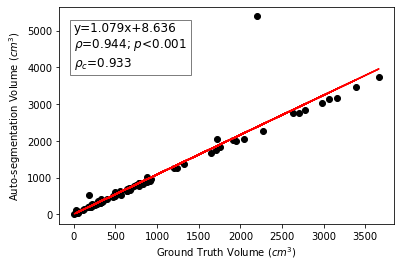

In [11]:
f, ax = plt.subplots()

ax.scatter(x, y, color='black')
ax.plot(x, predicts, color='red')

ax.set_xlabel("Ground Truth Volume ($cm^3$)")
ax.set_ylabel("Auto-segmentation Volume ($cm^3$)")

plt.text(0, 0.75*y.max(), "y=%5.3f"%(model.coef_)+"x+%5.3f"%(model.intercept_)+ 
         "\n" + "$\it{ρ}$" + "=%5.3f"%(pearson_coeff[0]) + "; $\it{p}$"+ "<0.001"
         "\n" + "$\it{ρ_c}$"+"=%5.3f"%(ccc0),
             fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.savefig("Fig6b.tiff", bbox_inches='tight', dpi=400)
plt.show()

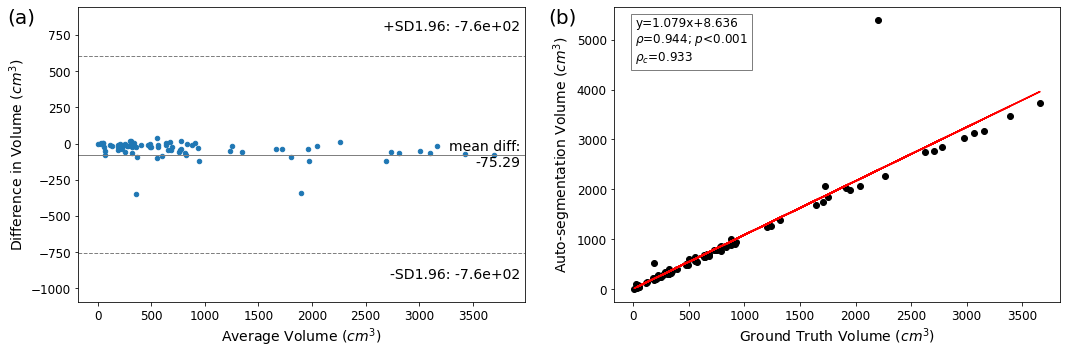

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sm.graphics.mean_diff_plot(df_comb['Volume_GT'], df_comb['Volume_PD'], ax = ax1)

ax1.set_xlabel("Average Volume ($cm^3$)", fontsize=14)
ax1.set_ylabel("Difference in Volume ($cm^3$)", fontsize=14)
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)

ax2.scatter(x, y, color='black')
ax2.plot(x, predicts, color='red')

ax2.set_xlabel("Ground Truth Volume ($cm^3$)", fontsize=14)
ax2.set_ylabel("Auto-segmentation Volume ($cm^3$)", fontsize=14)
ax2.xaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=12)

plt.text(0.005*x.max(), 0.85*y.max(), "y=%5.3f"%(model.coef_)+"x+%5.3f"%(model.intercept_)+ 
         "\n" + "$\it{ρ}$" + "=%5.3f"%(pearson_coeff[0]) + "; $\it{p}$"+ "<0.001"
         "\n" + "$\it{ρ_c}$"+"=%5.3f"%(ccc0),
             fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.text(-1.54*x.max(), 0.99*y.max(), "(a)", fontsize=20)
plt.text(-0.21*x.max(), 0.99*y.max(), "(b)", fontsize=20)
plt.subplots_adjust(wspace=0.2, hspace=0)


plt.savefig("./Figs/Fig6.tiff", bbox_inches='tight', dpi=400)
plt.show()